
--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...

 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 0.3643152713775635 seconds ---

gram matrix with parameters {'height': 0.0} is: 
[[  5.   6.   4. ...  20.  20.  20.]
 [  6.   8.   4. ...  20.  20.  20.]
 [  4.   4.   5. ...  21.  21.  21.]
 ...
 [ 20.  20.  21. ... 101. 101. 101.]
 [ 20.  20.  21. ... 101. 101. 101.]
 [ 20.  20.  21. ... 101. 101. 101.]]


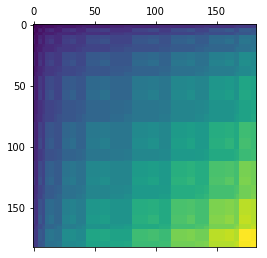


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 0.8394806385040283 seconds ---

gram matrix with parameters {'height': 1.0} is: 
[[ 10.  10.   4. ...  20.  20.  20.]
 [ 10.  16.   4. ...  20.  20.  20.]
 [  4.   4.  10. ...  22.  22.  24.]
 ...
 [ 20.  20.  22. ... 130. 130. 122.]
 [ 20.  20.  22. ... 130. 130. 122.]
 [ 20.  20.  24. ... 122. 122. 154.]]


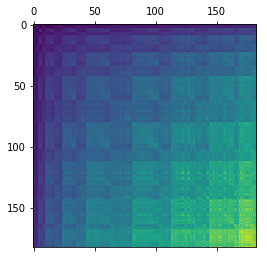


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 1.3557612895965576 seconds ---

gram matrix with parameters {'height': 2.0} is: 
[[ 15.   4.   0. ...   0.   0.   0.]
 [  4.  24.   0. ...   0.   0.   0.]
 [  0.   0.  15. ...   1.   1.   5.]
 ...
 [  0.   0.   1. ...  87.  58.  23.]
 [  0.   0.   1. ...  58.  67.  23.]
 [  0.   0.   5. ...  23.  23. 101.]]


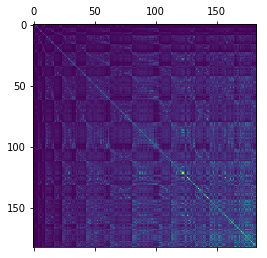


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 2.07392954826355 seconds ---

gram matrix with parameters {'height': 3.0} is: 
[[ 20.   0.   0. ...   0.   0.   0.]
 [  0.  32.   0. ...   0.   0.   0.]
 [  0.   0.  20. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 116.   8.   0.]
 [  0.   0.   0. ...   8.  60.   0.]
 [  0.   0.   0. ...   0.   0.  50.]]


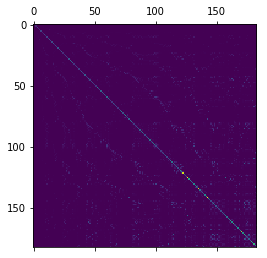


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 2.4412496089935303 seconds ---

gram matrix with parameters {'height': 4.0} is: 
[[ 25.   0.   0. ...   0.   0.   0.]
 [  0.  40.   0. ...   0.   0.   0.]
 [  0.   0.  25. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 145.   0.   0.]
 [  0.   0.   0. ...   0.  75.   0.]
 [  0.   0.   0. ...   0.   0.  55.]]


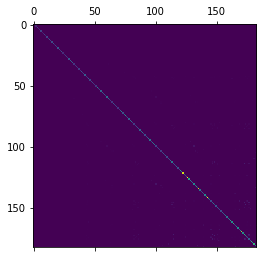


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 2.8024017810821533 seconds ---

gram matrix with parameters {'height': 5.0} is: 
[[ 30.   0.   0. ...   0.   0.   0.]
 [  0.  48.   0. ...   0.   0.   0.]
 [  0.   0.  30. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 174.   0.   0.]
 [  0.   0.   0. ...   0.  90.   0.]
 [  0.   0.   0. ...   0.   0.  66.]]


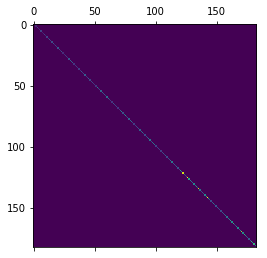


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 3.4581663608551025 seconds ---

gram matrix with parameters {'height': 6.0} is: 
[[ 35.   0.   0. ...   0.   0.   0.]
 [  0.  56.   0. ...   0.   0.   0.]
 [  0.   0.  35. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 203.   0.   0.]
 [  0.   0.   0. ...   0. 105.   0.]
 [  0.   0.   0. ...   0.   0.  77.]]


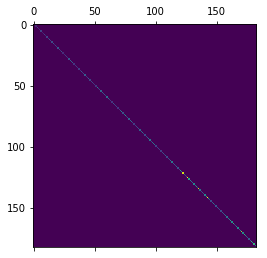


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 3.761540174484253 seconds ---

gram matrix with parameters {'height': 7.0} is: 
[[ 40.   0.   0. ...   0.   0.   0.]
 [  0.  64.   0. ...   0.   0.   0.]
 [  0.   0.  40. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 232.   0.   0.]
 [  0.   0.   0. ...   0. 120.   0.]
 [  0.   0.   0. ...   0.   0.  88.]]


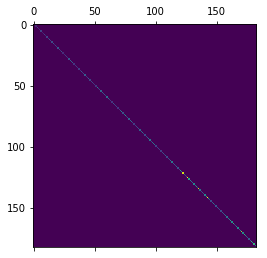


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 4.494075775146484 seconds ---

gram matrix with parameters {'height': 8.0} is: 
[[ 45.   0.   0. ...   0.   0.   0.]
 [  0.  72.   0. ...   0.   0.   0.]
 [  0.   0.  45. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 261.   0.   0.]
 [  0.   0.   0. ...   0. 135.   0.]
 [  0.   0.   0. ...   0.   0.  99.]]


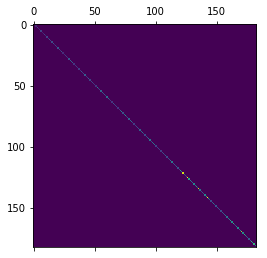


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 4.6411638259887695 seconds ---

gram matrix with parameters {'height': 9.0} is: 
[[ 50.   0.   0. ...   0.   0.   0.]
 [  0.  80.   0. ...   0.   0.   0.]
 [  0.   0.  50. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 290.   0.   0.]
 [  0.   0.   0. ...   0. 150.   0.]
 [  0.   0.   0. ...   0.   0. 110.]]


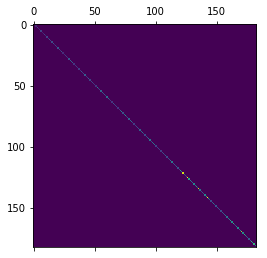


 --- Weisfeiler-Lehman subtree kernel matrix of size 183 built in 5.17179536819458 seconds ---

gram matrix with parameters {'height': 10.0} is: 
[[ 55.   0.   0. ...   0.   0.   0.]
 [  0.  88.   0. ...   0.   0.   0.]
 [  0.   0.  55. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 319.   0.   0.]
 [  0.   0.   0. ...   0. 165.   0.]
 [  0.   0.   0. ...   0.   0. 121.]]


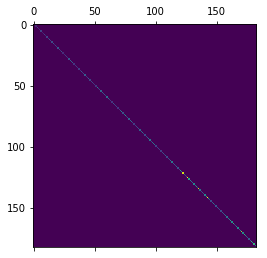


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 3/13530 [00:00<09:39, 23.34it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                            
4. Getting final performances...

best_params_out:  [{'height': 1.0}]
best_params_in:  [{'alpha': 0.12589254117941676}]
best_val_perf:  7.593412392539851
best_val_std:  0.7111794979520709
final_performance:  7.923917693852004
final_confidence:  2.919445947208125
train_performance:  5.9954331001158705
train_std:  0.26528917359193244
time to calculate gram matrix:  0.8394806385040283 s

params                                 train_perf         valid_perf               test_perf                gram_matrix_time
-------------------------------------  -----------------  -----------------------  ---------------------  ------------------
{'alpha': '1.00e-02', 'height': 0.0}   16.78±0.34         16.85±0.38               17.37±2.96                           0.36
{'alpha': '1.00e-02', 'height': 1.0}   5.93±0.30          7.91±0.84                8.40±3.39                            0.84
{'alpha': '1.00e-02', 'height': 2.0

calculate performance: 100%|██████████| 13530/13530 [14:10<00:00, 15.71it/s]

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = weisfeilerlehmankernel
param_grid_precomputed = {'height': np.linspace(0, 10, 11)}
param_grid = {'alpha': np.logspace(-2, 2, num = 41, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)


--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...

 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 0.8382418155670166 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 0.0} is: 
[[ 2.  1.  2. ...  0.  0.  1.]
 [ 1.  3.  1. ...  0.  0.  2.]
 [ 2.  1.  2. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ... 10.  7.  0.]
 [ 0.  0.  0. ...  7. 10.  1.]
 [ 1.  2.  1. ...  0.  1. 10.]]


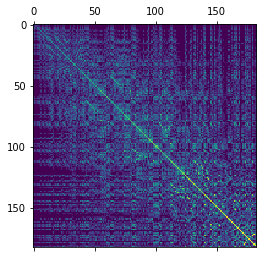


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 1.797783374786377 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 1.0} is: 
[[ 4.  2.  4. ...  0.  0.  2.]
 [ 2.  6.  2. ...  0.  0.  4.]
 [ 4.  2.  4. ...  0.  0.  2.]
 ...
 [ 0.  0.  0. ... 20. 14.  0.]
 [ 0.  0.  0. ... 14. 20.  2.]
 [ 2.  4.  2. ...  0.  2. 20.]]


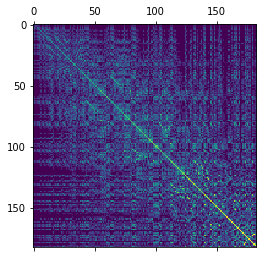


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 2.571061372756958 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 2.0} is: 
[[ 6.  3.  6. ...  0.  0.  3.]
 [ 3.  9.  3. ...  0.  0.  6.]
 [ 6.  3.  6. ...  0.  0.  3.]
 ...
 [ 0.  0.  0. ... 30. 21.  0.]
 [ 0.  0.  0. ... 21. 30.  3.]
 [ 3.  6.  3. ...  0.  3. 30.]]


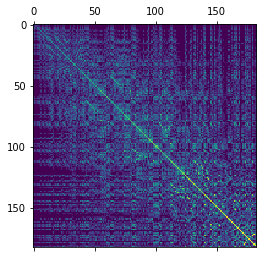


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 3.4686691761016846 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 3.0} is: 
[[ 8.  4.  8. ...  0.  0.  4.]
 [ 4. 12.  4. ...  0.  0.  8.]
 [ 8.  4.  8. ...  0.  0.  4.]
 ...
 [ 0.  0.  0. ... 40. 28.  0.]
 [ 0.  0.  0. ... 28. 40.  4.]
 [ 4.  8.  4. ...  0.  4. 40.]]


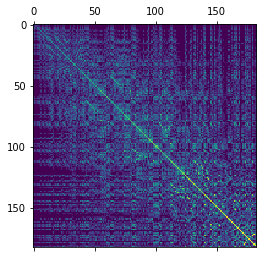


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 4.349034786224365 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 4.0} is: 
[[10.  5. 10. ...  0.  0.  5.]
 [ 5. 15.  5. ...  0.  0. 10.]
 [10.  5. 10. ...  0.  0.  5.]
 ...
 [ 0.  0.  0. ... 50. 35.  0.]
 [ 0.  0.  0. ... 35. 50.  5.]
 [ 5. 10.  5. ...  0.  5. 50.]]


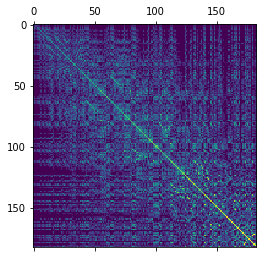


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 5.181172132492065 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 5.0} is: 
[[12.  6. 12. ...  0.  0.  6.]
 [ 6. 18.  6. ...  0.  0. 12.]
 [12.  6. 12. ...  0.  0.  6.]
 ...
 [ 0.  0.  0. ... 60. 42.  0.]
 [ 0.  0.  0. ... 42. 60.  6.]
 [ 6. 12.  6. ...  0.  6. 60.]]


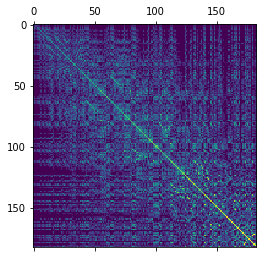


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 6.3245463371276855 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 6.0} is: 
[[14.  7. 14. ...  0.  0.  7.]
 [ 7. 21.  7. ...  0.  0. 14.]
 [14.  7. 14. ...  0.  0.  7.]
 ...
 [ 0.  0.  0. ... 70. 49.  0.]
 [ 0.  0.  0. ... 49. 70.  7.]
 [ 7. 14.  7. ...  0.  7. 70.]]


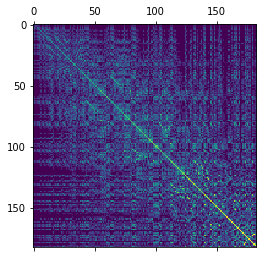


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 7.080430507659912 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 7.0} is: 
[[16.  8. 16. ...  0.  0.  8.]
 [ 8. 24.  8. ...  0.  0. 16.]
 [16.  8. 16. ...  0.  0.  8.]
 ...
 [ 0.  0.  0. ... 80. 56.  0.]
 [ 0.  0.  0. ... 56. 80.  8.]
 [ 8. 16.  8. ...  0.  8. 80.]]


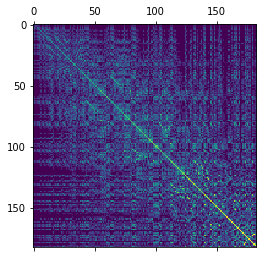


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 7.857206344604492 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 8.0} is: 
[[18.  9. 18. ...  0.  0.  9.]
 [ 9. 27.  9. ...  0.  0. 18.]
 [18.  9. 18. ...  0.  0.  9.]
 ...
 [ 0.  0.  0. ... 90. 63.  0.]
 [ 0.  0.  0. ... 63. 90.  9.]
 [ 9. 18.  9. ...  0.  9. 90.]]


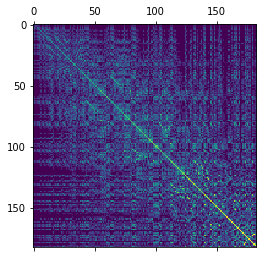


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 8.728142738342285 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 9.0} is: 
[[ 20.  10.  20. ...   0.   0.  10.]
 [ 10.  30.  10. ...   0.   0.  20.]
 [ 20.  10.  20. ...   0.   0.  10.]
 ...
 [  0.   0.   0. ... 100.  70.   0.]
 [  0.   0.   0. ...  70. 100.  10.]
 [ 10.  20.  10. ...   0.  10. 100.]]


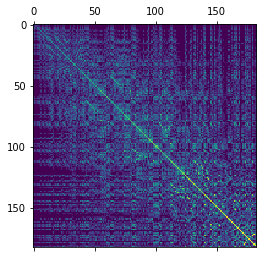


 --- Weisfeiler-Lehman edge kernel matrix of size 183 built in 9.403308153152466 seconds ---

gram matrix with parameters {'base_kernel': 'edge', 'height': 10.0} is: 
[[ 22.  11.  22. ...   0.   0.  11.]
 [ 11.  33.  11. ...   0.   0.  22.]
 [ 22.  11.  22. ...   0.   0.  11.]
 ...
 [  0.   0.   0. ... 110.  77.   0.]
 [  0.   0.   0. ...  77. 110.  11.]
 [ 11.  22.  11. ...   0.  11. 110.]]


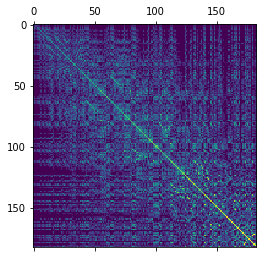


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 2/13530 [00:00<14:18, 15.75it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                            
4. Getting final performances...

best_params_out:  [{'base_kernel': 'edge', 'height': 4.0}]
best_params_in:  [{'alpha': 39.810717055349734}]
best_val_perf:  35.13329422064896
best_val_std:  0.7832828899376076
final_performance:  37.697602888271526
final_confidence:  6.917076511859134
train_performance:  30.10471658333036
train_std:  0.5666874899231609
time to calculate gram matrix:  4.349034786224365 s

params                                                        train_perf        valid_perf          test_perf             gram_matrix_time
------------------------------------------------------------  ----------------  ------------------  ------------------  ------------------
{'alpha': '1.00e-02', 'base_kernel': 'edge', 'height': 0.0}   49.55±29.71       84.81±62.30         83.10±69.42                       0.84
{'alpha': '1.00e-02', 'base_kernel': 'edge', 'height': 1.0}   57.14±115.85      101.64±220.27     

calculate performance: 100%|██████████| 13530/13530 [12:40<00:00, 17.72it/s]

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = weisfeilerlehmankernel
param_grid_precomputed = {'height': np.linspace(0, 10, 11), 'base_kernel': ['edge']}
param_grid = {'alpha': np.logspace(-2, 2, num = 41, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)


--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...

 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 13.253133296966553 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 0.0} is: 
[[ 3.  1.  3. ...  1.  1.  1.]
 [ 1.  6.  1. ...  0.  0.  3.]
 [ 3.  1.  3. ...  1.  1.  1.]
 ...
 [ 1.  0.  1. ... 55. 21.  7.]
 [ 1.  0.  1. ... 21. 55.  7.]
 [ 1.  3.  1. ...  7.  7. 55.]]


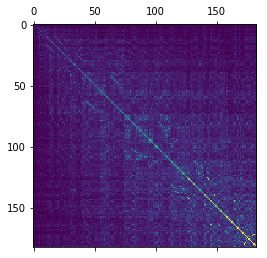


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 26.24978256225586 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 1.0} is: 
[[  6.   2.   6. ...   2.   2.   2.]
 [  2.  12.   2. ...   0.   0.   6.]
 [  6.   2.   6. ...   2.   2.   2.]
 ...
 [  2.   0.   2. ... 110.  42.  14.]
 [  2.   0.   2. ...  42. 110.  14.]
 [  2.   6.   2. ...  14.  14. 110.]]


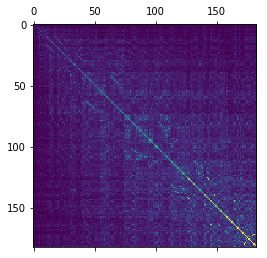


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 39.78876876831055 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 2.0} is: 
[[  9.   3.   9. ...   3.   3.   3.]
 [  3.  18.   3. ...   0.   0.   9.]
 [  9.   3.   9. ...   3.   3.   3.]
 ...
 [  3.   0.   3. ... 165.  63.  21.]
 [  3.   0.   3. ...  63. 165.  21.]
 [  3.   9.   3. ...  21.  21. 165.]]


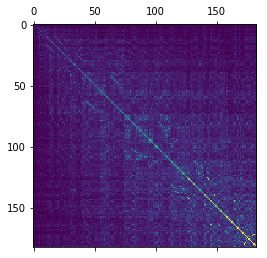


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 52.122785806655884 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 3.0} is: 
[[ 12.   4.  12. ...   4.   4.   4.]
 [  4.  24.   4. ...   0.   0.  12.]
 [ 12.   4.  12. ...   4.   4.   4.]
 ...
 [  4.   0.   4. ... 220.  84.  28.]
 [  4.   0.   4. ...  84. 220.  28.]
 [  4.  12.   4. ...  28.  28. 220.]]


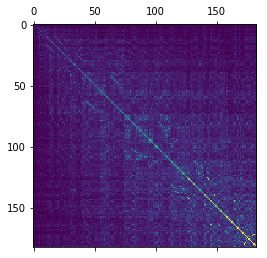


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 64.37597727775574 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 4.0} is: 
[[ 15.   5.  15. ...   5.   5.   5.]
 [  5.  30.   5. ...   0.   0.  15.]
 [ 15.   5.  15. ...   5.   5.   5.]
 ...
 [  5.   0.   5. ... 275. 105.  35.]
 [  5.   0.   5. ... 105. 275.  35.]
 [  5.  15.   5. ...  35.  35. 275.]]


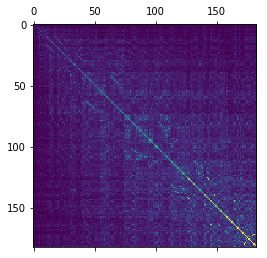


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 79.43934679031372 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 5.0} is: 
[[ 18.   6.  18. ...   6.   6.   6.]
 [  6.  36.   6. ...   0.   0.  18.]
 [ 18.   6.  18. ...   6.   6.   6.]
 ...
 [  6.   0.   6. ... 330. 126.  42.]
 [  6.   0.   6. ... 126. 330.  42.]
 [  6.  18.   6. ...  42.  42. 330.]]


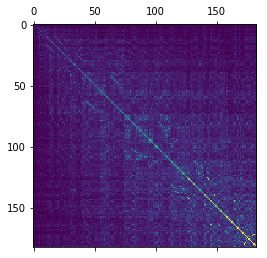


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 91.50003838539124 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 6.0} is: 
[[ 21.   7.  21. ...   7.   7.   7.]
 [  7.  42.   7. ...   0.   0.  21.]
 [ 21.   7.  21. ...   7.   7.   7.]
 ...
 [  7.   0.   7. ... 385. 147.  49.]
 [  7.   0.   7. ... 147. 385.  49.]
 [  7.  21.   7. ...  49.  49. 385.]]


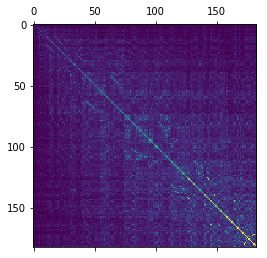


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 103.36761713027954 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 7.0} is: 
[[ 24.   8.  24. ...   8.   8.   8.]
 [  8.  48.   8. ...   0.   0.  24.]
 [ 24.   8.  24. ...   8.   8.   8.]
 ...
 [  8.   0.   8. ... 440. 168.  56.]
 [  8.   0.   8. ... 168. 440.  56.]
 [  8.  24.   8. ...  56.  56. 440.]]


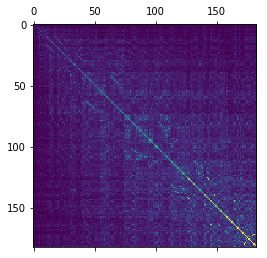


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 116.12333679199219 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 8.0} is: 
[[ 27.   9.  27. ...   9.   9.   9.]
 [  9.  54.   9. ...   0.   0.  27.]
 [ 27.   9.  27. ...   9.   9.   9.]
 ...
 [  9.   0.   9. ... 495. 189.  63.]
 [  9.   0.   9. ... 189. 495.  63.]
 [  9.  27.   9. ...  63.  63. 495.]]


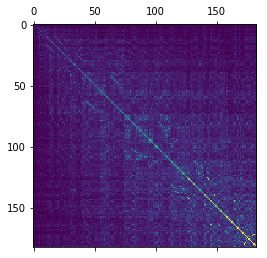


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 129.00585055351257 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 9.0} is: 
[[ 30.  10.  30. ...  10.  10.  10.]
 [ 10.  60.  10. ...   0.   0.  30.]
 [ 30.  10.  30. ...  10.  10.  10.]
 ...
 [ 10.   0.  10. ... 550. 210.  70.]
 [ 10.   0.  10. ... 210. 550.  70.]
 [ 10.  30.  10. ...  70.  70. 550.]]


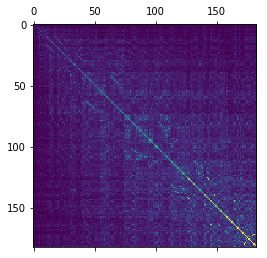


 --- Weisfeiler-Lehman sp kernel matrix of size 183 built in 142.7631003856659 seconds ---

gram matrix with parameters {'base_kernel': 'sp', 'height': 10.0} is: 
[[ 33.  11.  33. ...  11.  11.  11.]
 [ 11.  66.  11. ...   0.   0.  33.]
 [ 33.  11.  33. ...  11.  11.  11.]
 ...
 [ 11.   0.  11. ... 605. 231.  77.]
 [ 11.   0.  11. ... 231. 605.  77.]
 [ 11.  33.  11. ...  77.  77. 605.]]


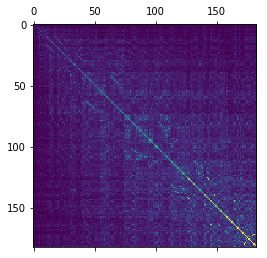


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 2/13530 [00:00<18:41, 12.07it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                            
4. Getting final performances...

best_params_out:  [{'base_kernel': 'sp', 'height': 2.0}]
best_params_in:  [{'alpha': 100.0}]
best_val_perf:  35.99396330118595
best_val_std:  0.975168619010553
final_performance:  37.92011979777975
final_confidence:  5.599617973456408
train_performance:  28.31827397760314
train_std:  0.6337452324001842
time to calculate gram matrix:  39.78876876831055 s

params                                                      train_perf            valid_perf             test_perf               gram_matrix_time
----------------------------------------------------------  --------------------  ---------------------  --------------------  ------------------
{'alpha': '1.00e-02', 'base_kernel': 'sp', 'height': 0.0}   6303.33±17673.66      12355.82±26031.70      23725.39±87669.55                  13.25
{'alpha': '1.00e-02', 'base_kernel': 'sp', 'height': 1.0}   11167.76±22193.97     41656.88±103

calculate performance: 100%|██████████| 13530/13530 [16:20<00:00, 14.10it/s]

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = weisfeilerlehmankernel
param_grid_precomputed = {'height': np.linspace(0, 10, 11), 'base_kernel': ['sp']}
param_grid = {'alpha': np.logspace(-2, 2, num = 41, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)

In [1]:
# wl subtree kernel
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel, _wl_subtreekernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type')

kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
    hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)

# %lprun -f _wl_subtreekernel_do \
#     kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
#     hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)


 --- This is a regression problem ---


 #--- calculating kernel matrix when height = 0.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman subtree kernel matrix of size 185 built in 0.3646550178527832 seconds ---
[[  5.   6.   4. ...  20.  20.  20.]
 [  6.   8.   4. ...  20.  20.  20.]
 [  4.   4.   5. ...  21.  21.  21.]
 ...
 [ 20.  20.  21. ... 101. 101. 101.]
 [ 20.  20.  21. ... 101. 101. 101.]
 [ 20.  20.  21. ... 101. 101. 101.]]

 Starting calculate accuracy/rmse...
calculate performance:  98%|█████████▊| 985/1000 [00:01<00:00, 664.77it/s]
 Mean performance on train set: 17.681582
With standard deviation: 0.713183

 Mean performance on test set: 15.685879
With standard deviation: 4.139197
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 681.36it/s]


 #--- calculating kernel matrix when height = 1.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- 


 --- Weisfeiler-Lehman subtree kernel matrix of size 185 built in 4.984841585159302 seconds ---
[[ 55.  10.   4. ...  20.  20.  20.]
 [ 10.  88.   4. ...  20.  20.  20.]
 [  4.   4.  55. ...  22.  22.  26.]
 ...
 [ 20.  20.  22. ... 391. 159. 124.]
 [ 20.  20.  22. ... 159. 273. 124.]
 [ 20.  20.  26. ... 124. 124. 279.]]

 Starting calculate accuracy/rmse...
calculate performance:  94%|█████████▍| 942/1000 [00:01<00:00, 708.78it/s]
 Mean performance on train set: 0.691516
With standard deviation: 0.564621

 Mean performance on test set: 17.186401
With standard deviation: 4.056724
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 711.43it/s]


  height    rmse_test    std_test    rmse_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     15.6859      4.1392      17.6816       0.713183  0.364655
       1      7.55046     2.33179      6.27001      0.654734  0.753551
       2      9.72847     2.05767      4.45068   

In [2]:
# WL sp kernel
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel, _wl_subtreekernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type', base_kernel = 'sp')

kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
    hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)

# %lprun -f _wl_subtreekernel_do \
#     kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
#     hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)


 --- This is a regression problem ---


 #--- calculating kernel matrix when height = 0.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman sp kernel matrix of size 185 built in 13.473959922790527 seconds ---

 Starting calculate accuracy/rmse...
calculate performance:  99%|█████████▊| 986/1000 [00:01<00:00, 802.19it/s]
 Mean performance on train set: 28.360361
With standard deviation: 1.357183

 Mean performance on test set: 35.191954
With standard deviation: 4.495767
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 805.00it/s]


 #--- calculating kernel matrix when height = 1.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman sp kernel matrix of size 185 built in 27.61470603942871 seconds ---

 Starting calculate accuracy/rmse...
calculate performance:  96%|█████████▌| 959/1000 [00:01<00:00, 734.53it/s]
 Mean performance on train set: 27

KeyboardInterrupt: 

In [2]:
# WL edge kernel
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel, _wl_subtreekernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type', base_kernel = 'edge')

kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
    hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)

# %lprun -f _wl_subtreekernel_do \
#     kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
#     hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

 --- This is a regression problem ---


 #--- calculating kernel matrix when height = 0.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman edge kernel matrix of size 185 built in 0.8530018329620361 seconds ---
[[ 2.  1.  2. ...  0.  0.  1.]
 [ 1.  3.  1. ...  0.  0.  2.]
 [ 2.  1.  2. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ... 10.  7.  0.]
 [ 0.  0.  0. ...  7. 10.  1.]
 [ 1.  2.  1. ...  0.  1. 10.]]

 Starting calculate accuracy/rmse...
calculate performance:  95%|█████████▍| 947/1000 [00:01<00:00, 719.29it/s]
 Mean performance on train set: 29.997498
With standard deviation: 0.902340

 Mean performance on test set: 33.407740
With standard deviation: 4.732717
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 653.54it/s]


 #--- calculating kernel matrix when height = 1.0 ---#

 Loading dataset from file...

 Calcu

calculate performance:  97%|█████████▋| 970/1000 [00:01<00:00, 694.38it/s]
 Mean performance on train set: 29.924232
With standard deviation: 0.790843

 Mean performance on test set: 33.416469
With standard deviation: 4.731694
calculate performance: 100%|██████████| 1000/1000 [00:01<00:00, 678.72it/s]


  height    rmse_test    std_test    rmse_train    std_train     k_time
--------  -----------  ----------  ------------  -----------  ---------
       0      33.4077     4.73272       29.9975     0.90234    0.853002
       1      33.4235     4.72131       30.1603     1.09423    1.71751
       2      33.433      4.72441       29.9286     0.787941   2.66032
       3      33.4073     4.73243       30.0114     0.909674   3.47763
       4      33.4256     4.72166       30.1842     1.1089     4.54367
       5      33.4067     4.72641       30.0411     1.01845    5.66178
       6      33.419      4.73075       29.9056     0.782179   6.14803
       7      33.4248     4.72155       30.1759     1

In [1]:
# results

# subtree with y normalization
  height    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     36.2108      7.33179      38.6059      1.57064   0.379475
       1      9.00098     6.37145       6.76379     1.96568   0.844898
       2     19.8113      4.04911       5.28757     1.81899   1.35308
       3     25.0455      4.94276       2.3274      0.805733  1.81136
       4     28.2255      6.5212        0.85156     0.423465  2.23098
       5     30.6354      6.73647       3.35947     8.17561   2.71575
       6     32.1027      6.85601       3.54105     8.71922   3.11459
       7     32.9709      6.89606       6.94372     9.94045   3.55571
       8     33.5112      6.90753       6.97339     9.76975   3.79657
       9     33.8502      6.91427      11.8345     11.6213    4.41555
      10     34.0963      6.93115      11.4257     11.2624    4.94888

# subtree without y normalization
  height    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     15.6859      4.1392      17.6816       0.713183  0.360443
       1      7.55046     2.33179      6.27001      0.654734  0.837389
       2      9.72847     2.05767      4.45068      0.882129  1.25317
       3     11.2961      2.79994      2.27059      0.481516  1.79971
       4     12.8083      3.44694      1.07403      0.637823  2.35346
       5     14.0179      3.67504      0.700602     0.57264   2.78285
       6     14.9184      3.80535      0.691515     0.56462   3.20764
       7     15.6295      3.86539      0.691516     0.56462   3.71648
       8     16.2144      3.92876      0.691515     0.56462   3.99213
       9     16.7257      3.9931       0.691515     0.56462   4.26315
      10     17.1864      4.05672      0.691516     0.564621  5.00918
    
# sp
  height    rmse_test    std_test    rmse_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0      35.192      4.49577       28.3604      1.35718   13.5041
       1      35.1808     4.50045       27.9335      1.44836   26.8292
       2      35.1632     4.50205       28.1113      1.50891   40.2356
       3      35.1946     4.49801       28.3903      1.36571   54.6704
       4      35.1753     4.50111       27.9746      1.46222   67.1522
       5      35.1997     4.5071        28.0184      1.45564   80.0881
       6      35.1645     4.49849       28.3731      1.60057   92.1925
       7      35.1771     4.5009        27.9604      1.45742  105.812
       8      35.1968     4.50526       28.1991      1.5149   119.022
       9      35.1956     4.50197       28.2665      1.30769  131.228
      10      35.1676     4.49723       28.4163      1.61596  144.964
    
# path
  height    rmse_test    std_test    rmse_train    std_train     k_time
--------  -----------  ----------  ------------  -----------  ---------
       0      33.4077     4.73272       29.9975     0.90234    0.853002
       1      33.4235     4.72131       30.1603     1.09423    1.71751
       2      33.433      4.72441       29.9286     0.787941   2.66032
       3      33.4073     4.73243       30.0114     0.909674   3.47763
       4      33.4256     4.72166       30.1842     1.1089     4.54367
       5      33.4067     4.72641       30.0411     1.01845    5.66178
       6      33.419      4.73075       29.9056     0.782179   6.14803
       7      33.4248     4.72155       30.1759     1.10382    7.60354
       8      33.4122     4.71554       30.1365     1.07485    7.97222
       9      33.4071     4.73193       30.0329     0.921065   9.07084
      10      33.4165     4.73169       29.9242     0.790843  10.0254

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [4]:
import sys
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.spkernel import spkernel

import matplotlib.pyplot as plt


def weisfeilerlehman_test(G):
    '''
    Weisfeiler-Lehman test of graph isomorphism.
    '''

    nx.draw_networkx(G)
    plt.show()
    nx.draw_networkx_labels(G, nx.spring_layout(G), labels = nx.get_node_attributes(G,'label'))
    print(G.nodes(data = True))
    
    set_multisets = []
    for node in G.nodes(data = True):
        # Multiset-label determination.
        multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
        # sorting each multiset
        multiset.sort()
        multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
        set_multisets.append(multiset)
        
    # label compression
#     set_multisets.sort() # this is unnecessary
    set_unique = list(set(set_multisets)) # set of unique multiset labels
    set_compressed = { value : str(set_unique.index(value)) for value in set_unique } # assign indices as the new labels
#     print(set_compressed)
#     print(set_multisets)
    
    # relabel nodes with multisets
    for node in G.nodes(data = True):
        node[1]['label'] = set_multisets[node[0]]
    print(' -> ')
    nx.draw_networkx(G)
    plt.show()
    print(G.nodes(data = True))

    
    # relabel nodes
    for node in G.nodes(data = True):
        node[1]['label'] = set_compressed[set_multisets[node[0]]]
        
    print(' -> ')
    nx.draw_networkx(G)
    plt.show()
    print(G.nodes(data = True))

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[12]
G2 = dataset[55]

# init.
kernel = 0 # init kernel
num_nodes1 = G1.number_of_nodes()
num_nodes2 = G2.number_of_nodes()

# the first iteration.
labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
print(labelset1)
print(labelset2)
kernel += spkernel(G1, G2)
print(kernel)



for height in range(0, min(num_nodes1, num_nodes2)): #Q how to determine the upper bound of the height?
    if labelset1 != labelset2:
        break
        
    # Weisfeiler-Lehman test of graph isomorphism.
    weisfeilerlehman_test(G1)
    weisfeilerlehman_test(G2)
    
    # calculate kernel
    kernel += spkernel(G1, G2)
    
    # get label sets of both graphs
    labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
    labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
#     print(labelset1)
#     print(labelset2)

print(kernel)

{'O', 'C'}
{'O', 'C'}


TypeError: 'int' object is not iterable

In [20]:
# test of WL subtree kernel on many graphs

import sys
import pathlib
from collections import Counter
sys.path.insert(0, "../")

import networkx as nx
import numpy as np
import time

from pygraph.kernels.spkernel import spkernel
from pygraph.kernels.pathKernel import pathkernel

def weisfeilerlehmankernel(*args, height = 0, base_kernel = 'subtree'):
    """Calculate Weisfeiler-Lehman kernels between graphs.
    
    Parameters
    ----------
    Gn : List of NetworkX graph
        List of graphs between which the kernels are calculated.
    /
    G1, G2 : NetworkX graphs
        2 graphs between which the kernel is calculated.
        
    height : subtree height
    
    base_kernel : base kernel used in each iteration of WL kernel
        the default base kernel is subtree kernel
        
    Return
    ------
    Kmatrix/Kernel : Numpy matrix/int
        Kernel matrix, each element of which is the Weisfeiler-Lehman kernel between 2 praphs. / Weisfeiler-Lehman Kernel between 2 graphs.
        
    Notes
    -----
    This function now supports WL subtree kernel and WL shortest path kernel.
    
    References
    ----------
    [1] Shervashidze N, Schweitzer P, Leeuwen EJ, Mehlhorn K, Borgwardt KM. Weisfeiler-lehman graph kernels. Journal of Machine Learning Research. 2011;12(Sep):2539-61.
    """
    if len(args) == 1: # for a list of graphs

#         print(args)
        start_time = time.time()
        
        # for WL subtree kernel
        if base_kernel == 'subtree':           
            Kmatrix = _wl_subtreekernel_do(args[0], height = height, base_kernel = 'subtree')
            
        # for WL edge kernel
        elif base_kernel == 'edge':
            print('edge')
            
        # for WL shortest path kernel
        elif base_kernel == 'sp':
            Gn = args[0]
            Kmatrix = np.zeros((len(Gn), len(Gn)))
            
            for i in range(0, len(Gn)):
                for j in range(i, len(Gn)):
                    Kmatrix[i][j] = _weisfeilerlehmankernel_do(Gn[i], Gn[j])
                    Kmatrix[j][i] = Kmatrix[i][j]

        print("\n --- Weisfeiler-Lehman %s kernel matrix of size %d built in %s seconds ---" % (base_kernel, len(args[0]), (time.time() - start_time)))
        
        return Kmatrix
        
    else: # for only 2 graphs
        
        start_time = time.time()
        
        # for WL subtree kernel
        if base_kernel == 'subtree':
            
            args = [args[0], args[1]]
#             print(args)
            kernel = _wl_subtreekernel_do(args, height = height, base_kernel = 'subtree')
            
        # for WL edge kernel
        elif base_kernel == 'edge':
            print('edge')
            
        # for WL shortest path kernel
        elif base_kernel == 'sp':
            

            kernel = _pathkernel_do(args[0], args[1])

        print("\n --- Weisfeiler-Lehman %s kernel built in %s seconds ---" % (base_kernel, time.time() - start_time))
        
        return kernel
    
    
def _weisfeilerlehmankernel_do(G1, G2):
    """Calculate Weisfeiler-Lehman kernels between 2 graphs. This kernel use shortest path kernel to calculate kernel between two graphs in each iteration.
    
    Parameters
    ----------
    G1, G2 : NetworkX graphs
        2 graphs between which the kernel is calculated.
        
    Return
    ------
    Kernel : int
        Weisfeiler-Lehman Kernel between 2 graphs.
    """
    
    # init.
    kernel = 0 # init kernel
    num_nodes1 = G1.number_of_nodes()
    num_nodes2 = G2.number_of_nodes()
    height = 12 #min(num_nodes1, num_nodes2)) #Q how to determine the upper bound of the height?
    
    # the first iteration.
    labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
    labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
    kernel += pathkernel(G1, G2) # change your base kernel here (and one more below)
    
    for h in range(0, height):
#         if labelset1 != labelset2:
#             break

        # Weisfeiler-Lehman test of graph isomorphism.
        relabel(G1)
        relabel(G2)

        # calculate kernel
        kernel += pathkernel(G1, G2) # change your base kernel here (and one more before)

        # get label sets of both graphs
        labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
        labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
    
    return kernel


def relabel(G):
    '''
    Relabel nodes in graph G in one iteration of the 1-dim. WL test of graph isomorphism.
    
    Parameters
    ----------
    G : NetworkX graph
        The graphs whose nodes are relabeled.
    '''
    
    # get the set of original labels
    labels_ori = list(nx.get_node_attributes(G, 'label').values())
    print(labels_ori)
    num_of_each_label = dict(Counter(labels_ori))
    print(num_of_each_label)
    num_of_labels = len(num_of_each_label)
    print(num_of_labels)
    
    set_multisets = []
    for node in G.nodes(data = True):
        # Multiset-label determination.
        multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
        # sorting each multiset
        multiset.sort()
        multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
        set_multisets.append(multiset)
    print(set_multisets)
        
    # label compression
#     set_multisets.sort() # this is unnecessary
    set_unique = list(set(set_multisets)) # set of unique multiset labels
    print(set_unique)
    set_compressed = { value : str(set_unique.index(value) + num_of_labels + 1) for value in set_unique } # assign new labels
    print(set_compressed)
    
    # relabel nodes
#     nx.relabel_nodes(G, set_compressed, copy = False)
    for node in G.nodes(data = True):
        node[1]['label'] = set_compressed[set_multisets[node[0]]]
    print(nx.get_node_attributes(G, 'label'))

    # get the set of compressed labels
    labels_comp = list(nx.get_node_attributes(G, 'label').values())
    print(labels_comp)
    num_of_each_label.update(dict(Counter(labels_comp)))
    print(num_of_each_label)
    
    
def _wl_subtreekernel_do(*args, height = 0, base_kernel = 'subtree'):
    """Calculate Weisfeiler-Lehman subtree kernels between graphs.
    
    Parameters
    ----------
    Gn : List of NetworkX graph
        List of graphs between which the kernels are calculated.
        
    Return
    ------
    Kmatrix/Kernel : Numpy matrix/int
        Kernel matrix, each element of which is the Weisfeiler-Lehman kernel between 2 praphs.
    """
    
#     print(args)
    Gn = args[0]
#     print(Gn)

    Kmatrix = np.zeros((len(Gn), len(Gn)))
    all_num_of_labels_occured = 0 # number of the set of letters that occur before as node labels at least once in all graphs
    
    # initial for height = 0
    print('\n --- height = 0 --- ')
    all_labels_ori = set() # all unique orignal labels in all graphs in this iteration
    all_num_of_each_label = [] # number of occurence of each label in each graph in this iteration
    all_set_compressed = {} # a dictionary mapping original labels to new ones in all graphs in this iteration
    num_of_labels_occured = all_num_of_labels_occured # number of the set of letters that occur before as node labels at least once in all graphs

    # for each graph
    for idx, G in enumerate(Gn):
        # get the set of original labels
        print('\n --- for graph %d --- \n' % (idx))
        labels_ori = list(nx.get_node_attributes(G, 'label').values())
        print('labels_ori: %s' % (labels_ori))
        all_labels_ori.update(labels_ori)
        print('all_labels_ori: %s' % (all_labels_ori))
        num_of_each_label = dict(Counter(labels_ori)) # number of occurence of each label in graph
        print('num_of_each_label: %s' % (num_of_each_label))
        all_num_of_each_label.append(num_of_each_label)
        print('all_num_of_each_label: %s' % (all_num_of_each_label))
        num_of_labels = len(num_of_each_label) # number of all unique labels
        print('num_of_labels: %s' % (num_of_labels))
        

        all_labels_ori.update(labels_ori)
        print('all_labels_ori: %s' % (all_labels_ori))
        
    all_num_of_labels_occured += len(all_labels_ori)
    print('\n all_num_of_labels_occured: %s' % (all_num_of_labels_occured))
        
    # calculate subtree kernel with the 0th iteration and add it to the final kernel
    print('\n --- calculating kernel matrix ---')
    for i in range(0, len(Gn)):
        for j in range(i, len(Gn)):
            labels = set(list(all_num_of_each_label[i].keys()) + list(all_num_of_each_label[j].keys()))
            print('\n labels: %s' % (labels))
            vector1 = np.matrix([ (all_num_of_each_label[i][label] if (label in all_num_of_each_label[i].keys()) else 0) for label in labels ])
            vector2 = np.matrix([ (all_num_of_each_label[j][label] if (label in all_num_of_each_label[j].keys()) else 0) for label in labels ])
            print('vector1: %s' % (vector1))
            print('vector2: %s' % (vector2))
            Kmatrix[i][j] += np.dot(vector1, vector2.transpose())
            Kmatrix[j][i] = Kmatrix[i][j]
            print('Kmatrix: %s' % (Kmatrix))

    
    # iterate each height
    for h in range(1, height + 1):
        print('\n --- height = %d --- ' % (h))
        all_set_compressed = {} # a dictionary mapping original labels to new ones in all graphs in this iteration
        num_of_labels_occured = all_num_of_labels_occured # number of the set of letters that occur before as node labels at least once in all graphs
        all_labels_ori = set()
        all_num_of_each_label = []
        
        # for each graph
        for idx, G in enumerate(Gn):
#             # get the set of original labels
            print('\n --- for graph %d --- \n' % (idx))
#             labels_ori = list(nx.get_node_attributes(G, 'label').values())
#             print('labels_ori: %s' % (labels_ori))
#             num_of_each_label = dict(Counter(labels_ori)) # number of occurence of each label in graph
#             print('num_of_each_label: %s' % (num_of_each_label))
#             num_of_labels = len(num_of_each_label) # number of all unique labels
#             print('num_of_labels: %s' % (num_of_labels))
            
#             all_labels_ori.update(labels_ori)
#             print('all_labels_ori: %s' % (all_labels_ori))
#             #             num_of_labels_occured += num_of_labels #@todo not precise
#             num_of_labels_occured = all_num_of_labels_occured + len(all_labels_ori) + len(all_set_compressed)
#             print('num_of_labels_occured: %s' % (num_of_labels_occured))
            
            set_multisets = []
            for node in G.nodes(data = True):
                # Multiset-label determination.
                multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
                # sorting each multiset
                multiset.sort()
                multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
                set_multisets.append(multiset)
            print('multiset: %s' % (set_multisets))

            # label compression
        #     set_multisets.sort() # this is unnecessary
            set_unique = list(set(set_multisets)) # set of unique multiset labels
            print('set_unique: %s' % (set_unique))
            # a dictionary mapping original labels to new ones. 
            set_compressed = {}
            # if a label occured before, assign its former compressed label, else assign the number of labels occured + 1 as the compressed label 
            for value in set_unique:
                if value in all_set_compressed.keys():
                    set_compressed.update({ value : all_set_compressed[value] })
                else:
                    set_compressed.update({ value : str(num_of_labels_occured + 1) })
                    num_of_labels_occured += 1
#             set_compressed = { value : (all_set_compressed[value] if value in all_set_compressed.keys() else str(set_unique.index(value) + num_of_labels_occured + 1)) for value in set_unique }
            print('set_compressed: %s' % (set_compressed))
            
            all_set_compressed.update(set_compressed)
            print('all_set_compressed: %s' % (all_set_compressed))
#             num_of_labels_occured += len(set_compressed) #@todo not precise
            print('num_of_labels_occured: %s' % (num_of_labels_occured))
            
            # relabel nodes
        #     nx.relabel_nodes(G, set_compressed, copy = False)
            for node in G.nodes(data = True):
                node[1]['label'] = set_compressed[set_multisets[node[0]]]
            print('\n compressed labels: %s' % (nx.get_node_attributes(G, 'label')))

            # get the set of compressed labels
            labels_comp = list(nx.get_node_attributes(G, 'label').values())
            print('labels_comp: %s' % (labels_comp))
            all_labels_ori.update(labels_comp)
            print('all_labels_ori: %s' % (all_labels_ori))
            num_of_each_label = dict(Counter(labels_comp))
            print('num_of_each_label: %s' % (num_of_each_label))
            all_num_of_each_label.append(num_of_each_label)
            print('all_num_of_each_label: %s' % (all_num_of_each_label))
                    
        all_num_of_labels_occured += len(all_labels_ori)
        print('\n all_num_of_labels_occured: %s' % (all_num_of_labels_occured))
        
        # calculate subtree kernel with h iterations and add it to the final kernel
        print('\n --- calculating kernel matrix ---')
        for i in range(0, len(Gn)):
            for j in range(i, len(Gn)):
                labels = set(list(all_num_of_each_label[i].keys()) + list(all_num_of_each_label[j].keys()))
                print('\n labels: %s' % (labels))
                vector1 = np.matrix([ (all_num_of_each_label[i][label] if (label in all_num_of_each_label[i].keys()) else 0) for label in labels ])
                vector2 = np.matrix([ (all_num_of_each_label[j][label] if (label in all_num_of_each_label[j].keys()) else 0) for label in labels ])
                print('vector1: %s' % (vector1))
                print('vector2: %s' % (vector2))
                Kmatrix[i][j] += np.dot(vector1, vector2.transpose())
                Kmatrix[j][i] = Kmatrix[i][j]
                    
        print('\n Kmatrix: %s' % (Kmatrix))

    return Kmatrix

    
# main
import sys
from collections import Counter
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.spkernel import spkernel

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[15]
print(nx.get_node_attributes(G1, 'label'))
G2 = dataset[80]
print(nx.get_node_attributes(G2, 'label'))

weisfeilerlehmankernel(G1, G2, height = 2)
# Kmatrix = weisfeilerlehmankernel(G1, G2)

{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'O', 6: 'O'}
{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'S', 7: 'S'}

 --- height = 0 --- 

 --- for graph 0 --- 

labels_ori: ['C', 'C', 'C', 'C', 'C', 'O', 'O']
all_labels_ori: {'C', 'O'}
num_of_each_label: {'C': 5, 'O': 2}
all_num_of_each_label: [{'C': 5, 'O': 2}]
num_of_labels: 2
all_labels_ori: {'C', 'O'}

 --- for graph 1 --- 

labels_ori: ['C', 'C', 'C', 'C', 'C', 'C', 'S', 'S']
all_labels_ori: {'C', 'O', 'S'}
num_of_each_label: {'C': 6, 'S': 2}
all_num_of_each_label: [{'C': 5, 'O': 2}, {'C': 6, 'S': 2}]
num_of_labels: 2
all_labels_ori: {'C', 'O', 'S'}

 all_num_of_labels_occured: 3

 --- calculating kernel matrix ---

 labels: {'C', 'O'}
vector1: [[5 2]]
vector2: [[5 2]]
Kmatrix: [[ 29.   0.]
 [  0.   0.]]

 labels: {'C', 'O', 'S'}
vector1: [[5 2 0]]
vector2: [[6 0 2]]
Kmatrix: [[ 29.  30.]
 [ 30.   0.]]

 labels: {'C', 'S'}
vector1: [[6 2]]
vector2: [[6 2]]
Kmatrix: [[ 29.  30.]
 [ 30.  40.]]

 --- height = 1 --- 

 --- for 

array([[ 55.,  36.],
       [ 36.,  72.]])